# Import Libraries

In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

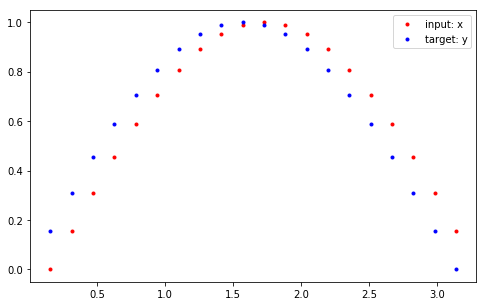

In [3]:
plt.figure(figsize=(8,5))

#How many time steps/data pts are in one batch of data
seq_length = 20

#Generate evenly spaced data pts
time_steps = np.linspace(0, np.pi, seq_length+1)

# Sin because of shape and predictability
data = np.sin(time_steps)

data.resize((seq_length +1, 1))

# All but the last piece
x = data[:-1]

# All but the first
y = data[1:]

plt.plot(time_steps[1:], x, 'r.', label = 'input: x')
plt.plot(time_steps[1:], y, 'b.', label = 'target: y')

plt.legend(loc = 'best')
plt.show()

# Define RNN

**input_size** - the size of the input  
**hidden_dim** - the number of features in the RNN output and in the hidden state  
**n_layers** - The number of layers that make up the RNN, typically 1-3, greater than one means that it will be stacked RNN  
**batch_first** - Whether or not the input/output of the RNN will have the batch_size as the first dimension(batch_size, seq_length, hidden_dim)

In [4]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(RNN, self).__init__()
        
        self.hidden_dim = hidden_dim
        # Batch_first means the first dim of the input and output will be the batch_size
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_dim, output_size)
        
    def forward(self, x, hidden):
        # x (batch_size, seq_length, input_size)
        # hidden (n_layers, batch_size, hidden_dim)
        # r_out (batch_size, time-step, hidden_size) 
        batch_size = x.size(0)
        
        # get RNN outputs
        r_out, hidden = self.rnn(x, hidden)
        # shape output to be (batch_size*seq_length, hidden_dim)
        r_out = r_out.view(-1, self.hidden_dim)
        
        # Get final output
        output = self.fc(r_out)
        
        return output, hidden

# Check the input and output dimensions

In [8]:
# Hidden_dim = The number of features expect to generate with the RNN layer

# Test
test_rnn = RNN(input_size=1, output_size=1, hidden_dim=10, n_layers=2) 

# Generate evenly spaced, test points
time_steps = np.linspace(0, np.pi, seq_length)
data = np.sin(time_steps)

data.resize((seq_length, 1))


test_input = torch.Tensor(data).unsqueeze(0) # Give it a batch_size of 1 as first dimension
print('Input size: ', test_input.size())

# Test out rnn sizes

test_out, test_h = test_rnn(test_input, None)
print('Output size: ', test_out.size())
print('Hidden state size', test_h.size())


Input size:  torch.Size([1, 20, 1])
Output size:  torch.Size([20, 1])
Hidden state size torch.Size([2, 1, 10])


# Training

In [11]:
input_size = 1
output_size = 1
hidden_dim = 32
n_layer = 1

#Instantiate an RNN
rnn = RNN(input_size, output_size, hidden_dim, n_layer)
print(rnn)

RNN(
  (rnn): RNN(1, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


### Loss and Optimization

In [13]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr = 0.01)

In [25]:
def train(rnn, n_steps, print_every):
    
    #initialize the hidden state
    hidden = None
    
    for batch_i, step in enumerate(range(n_steps)):
        # Defining the training data
        time_steps = np.linspace(step*np.pi, (step+1)*np.pi, seq_length+1)
        data = np.sin(time_steps)
        data.resize((seq_length+1, 1)) #Input size = 1
        
        x = data[:-1]
        y = data[1:]
        
        # Convert data into Tensors
        x_tensor = torch.Tensor(x).unsqueeze(0)
        y_tensor = torch.Tensor(y)
        
        # outputs from the run
        prediction, hidden = rnn(x_tensor, hidden)
        
        ## Representing Memory
        # make a new variable for hidden and detach the hidden state from its history
        # this way, we don't backpropagate through the entire history
        hidden = hidden.data
        
        loss = criterion(prediction, y_tensor)
        
        optimizer.zero_grad()
        
        loss.backward()
        optimizer.step()
        
        if batch_i % print_every == 0:
            print('Loss: ', loss.item())
            plt.plot(time_steps[1:], x, 'r.')
            plt.plot(time_steps[1:], prediction.data.numpy().flatten(), 'b.')
            plt.show()
        
    return rnn
        

Loss:  0.058415062725543976


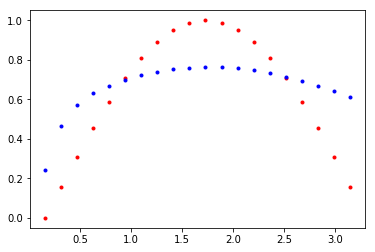

Loss:  0.05418854206800461


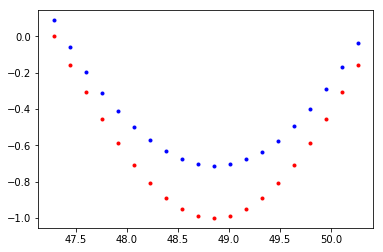

Loss:  0.0029381702188402414


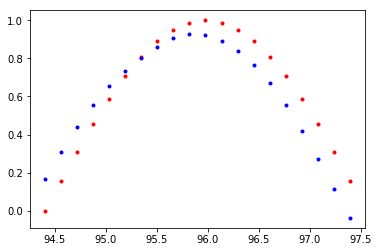

Loss:  0.0011314296862110496


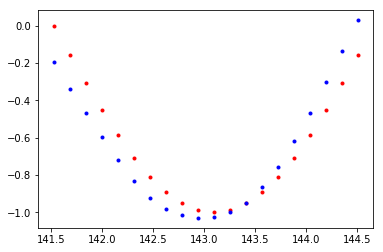

Loss:  0.0003345624718349427


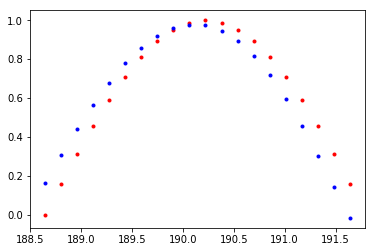

Loss:  0.00012373895151540637


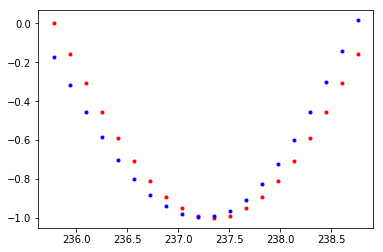

Loss:  0.00017642916645854712


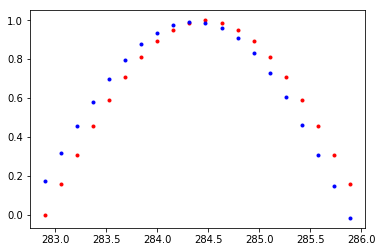

In [26]:
n_steps = 100
print_every = 15

trained_rnn = train(rnn, n_steps, print_every)